## Outlier Detection using Supervised Machine Learning 

Outlier detection is not straightforward, mainly due to the ambiguity surrounding the definition of what an outlier is specific to our data or the problem that we are trying to solve. Having domain knowledge is vital to making the proper judgment when spotting outliers. 

Most of the ML methods techniques for outlier detection are considered unsupervised outlier detection methods, such as **Isolation Forests (iForest), unsupervised K-Nearest Neighbors (KNN), Local Outlier Factor (LOF) and Copula-Based Outlier Detection (COPOD)** 

Generally, outliers (or anomalies) are considered a rare occurrence. In other words, we would assume a small fraction of our data are outliers in a large data set. For example, 1% of the data may be potential outliers. However, this complexity requires methods designed to find patterns in the data. Unsupervised outlier detection techniques are great at finding patterns in rare occurrences. 

After investigating outliers, we will have a historical set of labeled data, allowing us to leverage semi-supervised outlire detection techniques.

Here we will introduce the **PyOD** library, described as "a comprehensive and scalable Python toolkit for detecting outlying objects in multivariate data". 

In [1]:
import pyod 

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from pathlib import Path 
import warnings 
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [16,3]


In [3]:
# load the nyc taxi dataset 
file = Path("../TimeSeriesAnalysisWithPythonCookbook/Data/nyc_taxi.csv")
nyc_taxi = pd.read_csv(file, index_col='timestamp', parse_dates=True)
nyc_taxi.index.freq = "30T"

In [4]:
# Store the known dates containing outliers, also known as ground truth labels

nyc_dates = [
    "2014-11-01",
    "2014-11-27",
    "2014-12-25",
    "2015-01-01",
    "2015-01-27"
]


In [5]:
# Create the plot_outliers function that we will use throughout 

def plot_outliers(outliers, data, method='KNN', 
                  halignment = 'right', 
                  valignment = 'top', 
                  labels=False):
    ax = data.plot(alpha=0.6)

    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'v', markersize=8, markerfacecolor='none', markeredgecolor='k')
            plt.text(i[0], i[1]-(i[1]*0.04), f'{i[0].strftime("%m/%d")}', 
                     horizontalalignment=halignment, 
                     verticalalignment=valignment)
    
    else:
        data.loc[outliers.index].plot(ax=ax, style='rX', markersize=9)
    
    plt.title(f'NYC Taxi - {method}')
    plt.xlabel('date')
    plt.ylabel('# of passengers')
    plt.legend(['nyc taxi', 'outliers'])
    plt.show()

As we proceed the goal is to see how the different techniques capture outliers and compare them to the ground truth labels

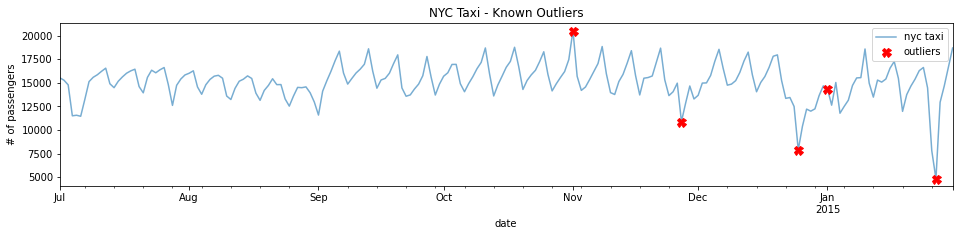

In [6]:
# Creates plot with known outliers marked with red x markers for the known outliers

tx = nyc_taxi.resample('D').mean()
known_outliers = tx.loc[nyc_dates]
plot_outliers(known_outliers, tx, 'Known Outliers')

Like scikit-learn, PyOD offers familiar methods for training our model and making predictions by providing three methods: model.fit(), model.predict() and model.fit_predict()

In addition to the predict method, PyOD provides two additional methods: predict_proba and predict_confidence

## Detecting outliers using KNN 

The KNN algorithm is typically used in a supervised learning setting where prior results or outcomes are known

It can be used to solve classification or regression problems. The idea is simple; we can classifiy a new data point, Y, based on its nearest neighbours. If k=5, the algorithm will find the five nearest data potins by distance to the point Y and determine its class based on the majority. If there are three blue and two red neighbors, Y is classified as blue. The K in KNN is a parameter we can modify to find the optimal value

In the case of outlier detection, the algorithm is used differently. Since we do not know the outliers in advance, KNN is used in an unsupervised learning manner. In this scenario, the algorithm finds the closest K nearest neighbors for every data point and measures the average distance. The points with the most significant distance from the population will be considered outliers, and more specifically, they are considered global outliers. In this case, the distance becomes the score to determine which points are outliers among the population, and hence KNN is a proximity-based algorithm

Generally, proximity-based algortihms rely on the distance or proximity between an outlier point and its nearest neighbors. In KNN, the number of nearest neighbors, k, is a parameter we need to determine. There are other variants of the KNN algorithm supported by PyOD, for example, Average KNN (AvgKNN) which uses the average distance to the KNN for scoring, and median KNN (medKNN) which uses the median distance for scoring. 

In [7]:
# Start by loading the KNN class 
from pyod.models.knn import KNN


We should be familiar with a few parameters to control the algorithm's behavior. The first parameter is contamination, a numeric (float) value representing the dataset's fraction of outliers. This is a common parameter across all the different classes in PyOD. For example, a contamination value of 0.1 indicates that we expect 10% of the data to be outliers. The default value is contamination=0.1. 

The contamination value can range from 0 to 0.5 (or 50%). We will need to experiment with the contamination value, since the value influences the scoring threshold used to determine potential outliers, and how many of these potential outliers are to be returned. 

For example, if we suspect the proportion of outliers in our data at 3%, then we can use that as the contamination value. We could experiment with different contamination values, inspect the results, and determine how to adjuste the contamination level. We already know that there are 5 known outliers out of the 215 observations (around 2.3%), here we will use 0.03 (3%)

The second parameter, specfic to KNN, is method, which defaults to method='largest'. Here we will change it to the mean (the average of all K neighbor distances).

The third parameter, also specific to KNN, is metric, which tells the algorithm how to compute the distances. The default is the _minkowski_ distance but it can take any distance metrics from scikit-learn or the SciPy library. Finally, we need to provide the number of neighbors, which defaults to nNeighbors=5. Ideally, we will want to run for different KNN models with varying values of _k_ and compare the results to determine the optimal number of neighbors

In [8]:
# Instantiate KNN with the updated parameters and then train (fit) the model

knn = KNN(contamination=0.03, method='mean', n_neighbors=5)
knn.fit(tx)



KNN(algorithm='auto', contamination=0.03, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [9]:
# The predict method will generate binary labels, either 1 or 0 for each data point.
# A value of 1 indicates an outlier. Store the results in a Series

predicted = pd.Series(knn.predict(tx), 
                      index=tx.index)

print('Number of outliers = ', predicted.sum())

Number of outliers =  6


In [10]:
# Filter the predicted Series to only show the outlier values

outliers = predicted[predicted==1]
outliers = tx.loc[outliers.index]

outliers 

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


Overall, the results look promising; four out of the five known dates have been identified. Additionally, the algorithm identified the day after Christmas as well as January 26, 2015 which was when all vehicles were ordered off the streets due to a Blizzrd

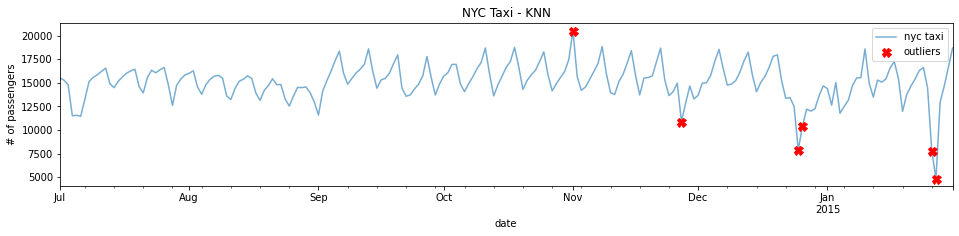

In [11]:
# Use the plot_outliers function to visualize the output to gain better insight
plot_outliers(outliers, tx, 'KNN')

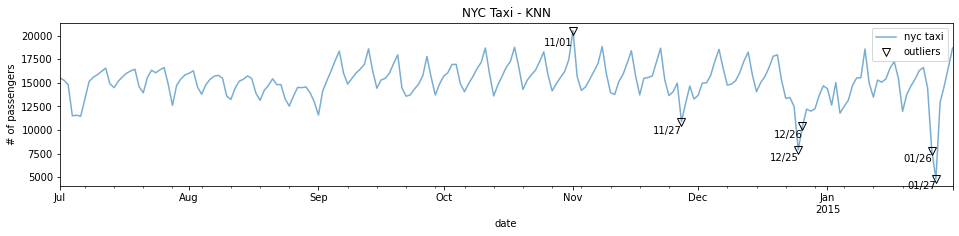

In [12]:
# To print the labels along with the markers, just call the plot_outliers function again, 
# but this time with labels=True

plot_outliers(outliers, tx, 'KNN', labels=True)

Let's create a function for the KNN algorithm to train the model on different scoring methods by updating the method parameter to either mean, median or largest to examine the impact on the decision scores:

* largest uses the largest distance to the kth neighbor as the outlier score
* mean uses the average of the distances to the _k_ neighbors as the outlier score
* median uses the median of the distances to the k neighbors as the outlier score



In [13]:
# Create the knn_anomaly function with the following parameters: data, method, contamination and K:

def knn_anomaly(df, method='mean', contamination=0.05, k=5):
    knn = KNN(contamination=contamination, 
              method=method,
              n_neighbors=5)
    knn.fit(df)
    decision_score = pd.DataFrame(knn.decision_scores_, 
                                  index=df.index, columns=['score'])
    
    n = int(len(df)*contamination)
    outliers = decision_score.nlargest(n, 'score')
    return outliers, knn.threshold_


In [14]:
# Explore how the different methods produce a different threshold, which impacts the outliers 
# being detected

for method in ['mean', 'median', 'largest']:
    o, t = knn_anomaly(tx, method=method)
    print(f'Method = {method}, Threshold= {t}')
    print(o)

Method = mean, Threshold= 220.32916666666603
                  score
timestamp              
2015-01-27  4862.058333
2015-01-26  2474.508333
2014-12-25  2441.250000
2014-11-01  1806.850000
2014-12-26  1009.616667
2014-11-27   608.250000
2014-09-27   225.604167
2014-07-06   224.208333
2014-12-28   223.562500
2015-01-19   223.562500
Method = median, Threshold= 211.64999999999995
                  score
timestamp              
2015-01-27  5563.416667
2014-12-25  2997.541667
2015-01-26  2984.437500
2014-11-01  1847.083333
2014-12-26  1113.812500
2014-11-27   612.104167
2014-12-29   251.520833
2014-12-27   238.062500
2015-01-19   238.062500
2014-12-28   219.145833
Method = largest, Threshold= 411.85624999999993
                  score
timestamp              
2015-01-27  6629.729167
2015-01-26  3645.291667
2014-12-25  3562.145833
2014-11-01  1865.437500
2014-12-26  1191.916667
2014-11-27   690.208333
2014-07-06   518.583333
2014-07-04   471.083333
2014-12-19   436.604167
2014-09-27   431.750

Notice the top six are identical for all three methods. The order may vary and the decision scores are different between the methods. Do notice the difference between the methods is more apparent beyond the top six 

## Detecting outliers using LOF 

Overall KNN does a good job of capturing global outliers, but those far from the surrounding points may not do well with identifying local outliers

This is where the LOF comes in to solve this limitation. Instead of using the distance between neighboring points, it uses density as a basis for scoring data points and detecting outliers. The LOF is considered a density-based algorithm. The idea behind the LOf is that outliers will be further from other data points and more isolated, and thus will be in low-density regions

It is easier to illustrate this with an example: imagine a person standing in line in a small but busy but busy Starbucks, and everyone is pretty much close to each other; then, we can say the person is in a high-density area and, more specifically, **high local density**. If the person decides to wait in their car in the parking lot until the line eases up, they are isolated and in a low-density area, thus being considered an outlier. From the perspective of the people standing in line, who are probably not aware of the person in the car, that person is considered not reachable even though that person on the car is not reachable from their perspective. Hence, we sometimes refer to this as **inverse reachability** (how far we are from the neighbors' perspective)

Like KNN, we still need to define the _k_ parameter for the number of nearest neighbors. The nearest neighbors are identified based on the distance measured between the observations (think KNN), the the **Local Reachability Density (LRD or local density)** is measured for each neighboring point. This local density is the score used to compare the kth neighboring observations and those with lower local densities that their kth neighbors are considered outliers

In [15]:
from pyod.models.lof import LOF 


We should be familiar with a few parameters to control the algorithm's behavior. The first parameter is _contamination_, a numeric (float) value representing the dataset's fraction of outliers. For example, a value of 0.1 indicates that we expect 10% of the data to be outliers. The default value is contamination=0.1

The second parameter is the number of neighbors, which defaults to n_neighbors=5, similar to the KNN algorithm. Ideally, we will want to run different models with varying values of k (n_neighbors) and compare the results to determine the optimal number of neighbors. Lastly, the metric parameter specifies which metric to use to calculate the distance. This can be any distance metrics from the scikit-learn or SciPy libraries (for example Euclidean or Manhattan distance). The default value is the Minkowski distance with metric='minkowski' 

Since the Minkowski distance is a generalization for both the Euclidean and Manhattan distances we will notice a p parameter. By default, p=2 indicates Euclidean distance, while a value of p=1 indicates Manhattan distance



In [16]:
# Instantiate LOF by updating n_neighbors=5 and contamination=0.03 while keeping the rest of 
# of the parameters with the default values. Then, train the model

lof = LOF(contamination=0.03, n_neighbors=5)
lof.fit(tx)


LOF(algorithm='auto', contamination=0.03, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=5, novelty=True, p=2)

In [17]:
# The predict method will output either 1 or 0 for each data point. A value of 1 indicates
# an outlier. Store the results in a Series

predicted = pd.Series(lof.predict(tx), 
                      index=tx.index) 

print('Number of outliers =', predicted.sum())


Number of outliers = 6


In [19]:
# Filter the predicted Series to only show the outlier values

outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index]

outliers

,value
timestamp,
2014-10-31,17473.354167
2014-11-01,20553.500000
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


Interestingly, it captured three out of the five known dates but managed to identify the day after Thanksgiving and the day after Crhistmas as outliers. Aditionally, Oct. 31 was on a Friday, and it was Halloween night


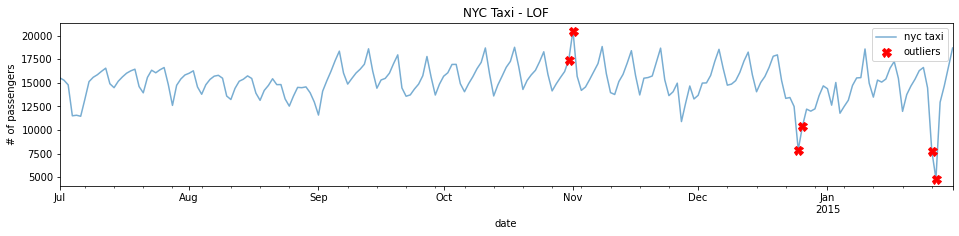

In [20]:
# Use the plot_outliers function to visualize the output to gain better insight
plot_outliers(outliers, tx, 'LOF')

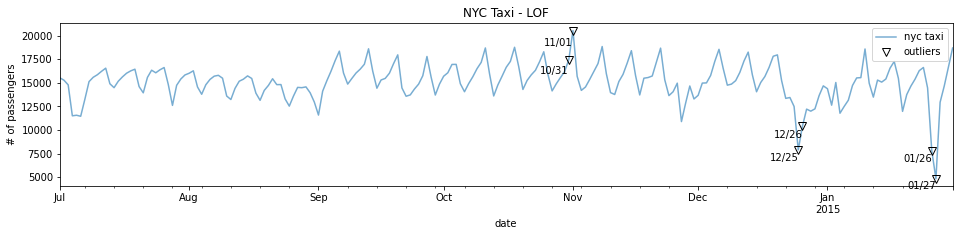

In [21]:
# Print with the labels

plot_outliers(outliers, tx, 'LOF', labels=True)

Like the LOF, another extension of the algo is the **Cluster-Based Local Outlier Factor (CBLOF)**. The CBLOF is similar to LOF in concept as it relies on cluster size and distance when calculating the scores to determine outliers. So, instead of the number of neighbors (n_neighbors like in LOF), we now have a new parameter, which is the number of clusters (n_clusters)

The default clustering estimator, clustering_estimator, in PyOD is the k-means clustering algorithm

We will use the CBLOF class from PyOD and keep most parameters at the default values. Change the n_clusters=8 and contamination=0.03 parameters:

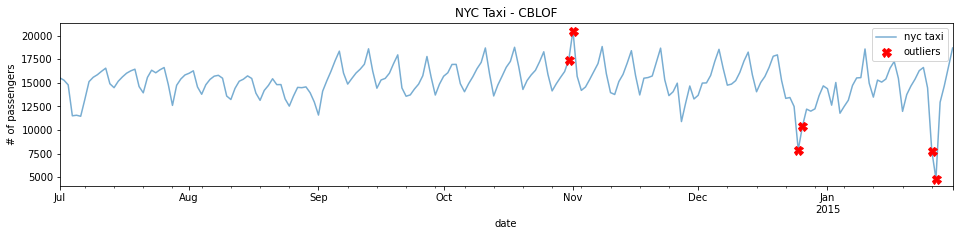

In [22]:
from pyod.models.cblof import CBLOF 

cblof = CBLOF(n_clusters=4, contamination=0.03)
cblof.fit(tx)
predicted = pd.Series(lof.predict(tx), 
                      index=tx.index)

outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index]
plot_outliers(outliers, tx, 'CBLOF')

## Detecting outliers using iForest

iForest has similarities with Random Forests. RF is a tree-based supervised learning algo. In supervised learning, we have existing labels (classification) or values (regression) representing the target variable. This is how the algo learns.

The name _forest_ stems from the underlying mechanism of how the algorithm works. For example, in classification, the algo randomly samples the data to build multiple weak classifiers (smaller decision trees) that collectively make a prediction. In the end, we get a forest of smaller trees (models). This technique outperforms a single complex classifier that may overfit the data. Ensemble learning is the concept of multiple weak learners collaborating to produce an optimal solution

iForest, also an _ensemble learning_ method, is the unsupervised learning approach to Random Forests. The iForest algo isolates anomalies by randomly partitioning (splitting) a dataset into multiple partitions. This is performed recursively until all data points belong to a partition. The number of partitions required to isolate an anomaly is typically smaller than the number of partitions needed to isolate a regular point. The idea is that an anomaly data point is futher from other points and thus easier to separate (isolate).

In contrast, a normal data point is probably clustered closer to the larger set and, therefore, will require more partitions (splits) to isolate that point. Hence the name, isolation forest, since it identifies outliers through isolation. Once all the points are isolated, the algo will create an outlier score. We can think of these splits as creating a decision tree path. The shorter the path length to a point, the higher the chances of an anomaly.

In [23]:
from pyod.models.iforest import IForest


There are a few parameters that we should be familiar with to control the algo's behavior. the first parameter is contamination. The default value is contamination =0.1 but here we will use 0.03

The second parameter is n_estimators, which defaults to n_estimators=100. This is the number of random trees generated. Depending on the complexity of our data, we may want to increase this value to a higher range, such as 500 or more. Start with the default smaller value to understand how the baseline model works. Finally random_state defaults to None. Since the iForest algo randomly generates partitions for the data, it is good to set a value to ensure that our work is reproducible. This way, we can get consistent results back when we rerun the code. This coulde be an integer value


In [25]:
# Instantiate IForest and update the contamination and random_state parameters. Then, fit the 
# new instance of the class (iforest) on the resampled data to train the model

iforest = IForest(contamination=0.03, 
                  n_estimators=100, 
                  random_state=0)

iforest.fit(nyc_taxi)

IForest(behaviour='old', bootstrap=False, contamination=0.03,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=0, verbose=0)

In [29]:
# Use the predict method to identify outliers. The method will output either 1 or 0 for each
# data point. For example, a value of 1 indicates an outlier

predicted = pd.Series(iforest.predict(tx), 
                      index=tx.index)

print('Number of outliers =', predicted.sum())


Number of outliers = 0


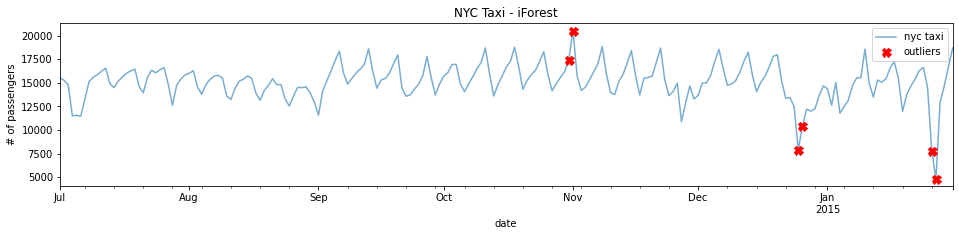

In [30]:
plot_outliers(outliers, tx, 'iForest')

The iForest algo from PyOD is a wrapper ti scikit-learn's IsolationForest class. This is also true for the KNN

Here we'll explore this further and use scikit-learn to implement iForest algorithm. We will use the fit_predict() method as a single step to train and predict, which is also available in PyOD's implementations across the various algorithms

In [31]:
from sklearn.ensemble import IsolationForest

sk_iforest = IsolationForest(contamination=0.03)
sk_prediction = pd.Series(sk_iforest.fit_predict(tx), 
                          index=tx.index)

sk_outliers = sk_prediction[sk_prediction == -1]
sk_outliers = tx.loc[sk_outliers.index]

sk_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-08,18857.333333
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


## Detecting outliers using One-Class Support Vector Machine 

SVMis a popular supervised ML algo that is mainly known for classification but can also be used for regression

The popularity of SVM comes from the use of kernel functions, such as the linear, polynomial, Radisu-Based Function and the sigmoid function 

In addition to classification and regression, SVM can also be uesd for outlier detection in an unsupervised manner, similar to KNN, which is mostly known as a supervised ML technique but was used in an unsupervised manner for outlier detection



In [32]:
from pyod.models.ocsvm import OCSVM 

There are a few parameters that we should be familiar with to control the algo's behavior. The first parameter is contamination. The default value is contamination=0.1, here we will use 0.03

The second parameter is kernel, which is set to rbf, which we will keep as is. 

Instantiate OCSVM by updating contamination=0.03 while keeping the rest of the parameters with the default values, Then, train the model

In [33]:
ocsvm = OCSVM(contamination=0.03, kernel='rbf')
ocsvm.fit(tx)


OCSVM(cache_size=200, coef0=0.0, contamination=0.03, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)

In [34]:
predicted = pd.Series(ocsvm.predict(tx), 
                      index=tx.index)

print('Number of outliers = ', predicted.sum())


Number of outliers =  5


In [35]:
# Filter the predicted Series to only show outlier values

outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index]
outliers 

,value
timestamp,
2014-08-09,15499.708333
2014-11-18,15499.437500
2014-11-27,10899.666667
2014-12-24,12502.000000
2015-01-05,12502.750000


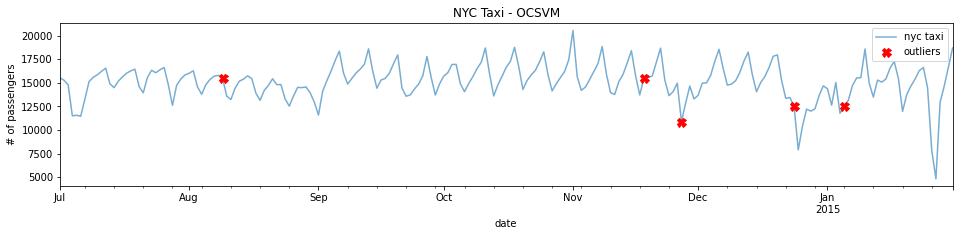

In [36]:
plot_outliers(outliers, tx, 'OCSVM')

When examining the plot, it is not clear why OCSVM picked up on those dates as being outliers. The RBF kernel can capture non-linear relationships, so we would expect it to be a robust kernel

The reason for this inaccuracy is that SVM is sensitive to data scaling. To get better results, we will need to standardize (scale) out data first. 



In [37]:
# Fix this issue and standardize the data and then rerun the algo again

from pyod.utils.utility import standardizer 
scaled = standardizer(tx)
predicted = pd.Series(ocsvm.fit_predict(scaled), 
                      index=tx.index)

outliers = predicted[predicted==1]
outliers = tx.loc[outliers.index]
outliers 

,value
timestamp,
2014-07-06,11464.270833
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


Interestingly, now the model identified four out of the five known outlier dates


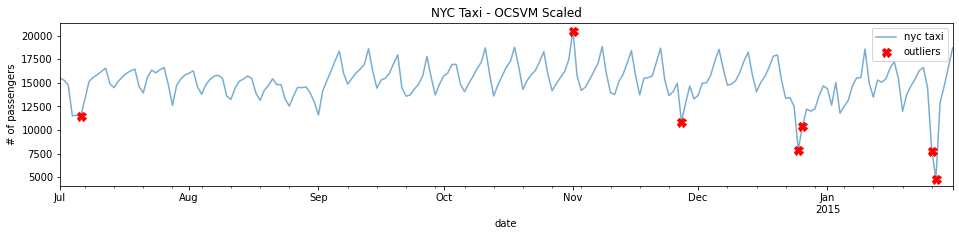

In [38]:
# Use the plot_outliers function on the new result set

plot_outliers(outliers, tx, 'OCSVM Scaled')

Let's explore how the different kernels perform on the same dataset. In the following, we test four kernels: 'linear', 'poly', 'rbf' and 'sigmoid'



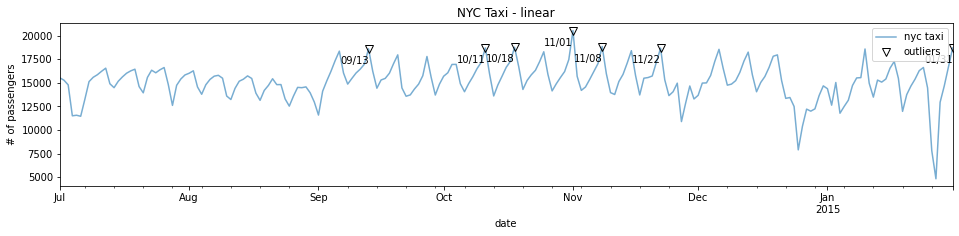

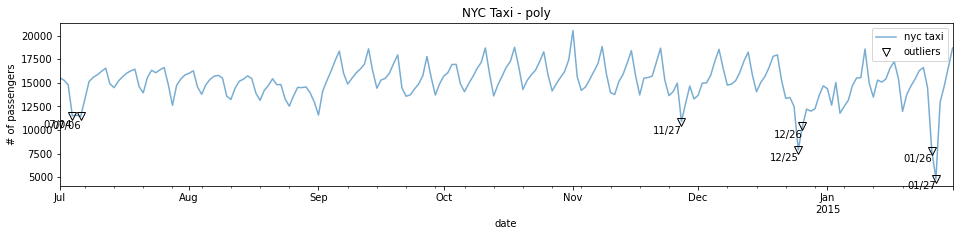

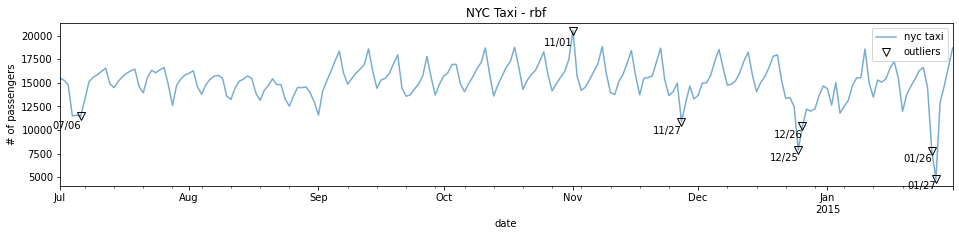

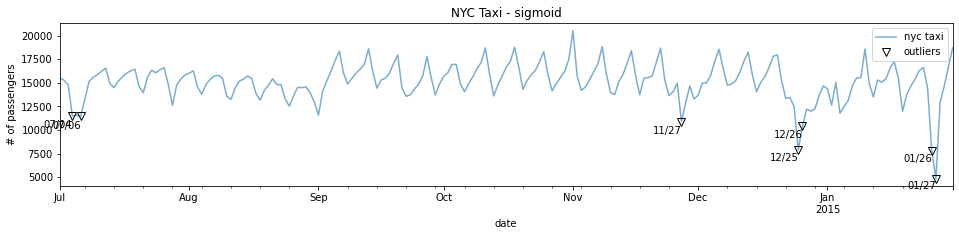

In [39]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    ocsvm = OCSVM(contamination=0.03, kernel=kernel)
    predict = pd.Series(ocsvm.fit_predict(scaled), 
                        index=tx.index, name=kernel)
    
    outliers = predict[predict==1]
    outliers = tx.loc[outliers.index]
    plot_outliers(outliers, tx, kernel, labels=True)

## Detecting outliers using COPOD 

COPOD falls under probabilistic models and is labeled as a parameter-free algo. The only parameter it takes is the contamination factor, which defaults to 0.1. The COPOD algorithm  is inspired by statistical methods, making it a fast and highly interpretable model. The algorithm is based on copula, a function generally used to model dependence between independent random variables that are not necessarily normally distributed. In time series forecasting, copulas have beed used in univariate and multivariate forecasting, which is popular in financial risk modeling. The term copula stems from the copula function joining (coupling) univariate marginal distributions to form a uniform multivariate distribution function. 



In [40]:
from pyod.models.copod import COPOD 


The only parameter we need to consider is contamination. Generally, think of this parameter as a threshold to control the model's sensitivity and minimize the false positives. Since it is a parameter we control, ideally, we want to run several models to experiment with the ideal threshold rate that works for our use cases


In [41]:
# Instantiate COPOD and update contamination to 0.03 
# Then fit on the resampled data to train the model

copod = COPOD(contamination=0.03)


In [42]:
copod.fit(tx)

COPOD(contamination=0.03, n_jobs=1)

In [43]:
COPOD(contamination=0.03, n_jobs=1)

COPOD(contamination=0.03, n_jobs=1)

In [44]:
# Use the predict method to identify outliers. The method will output either 1 or 0  for each
# data point. For example, a value of 1 indicates an outlier 

predicted = pd.Series(copod.predict(tx), 
                      index=tx.index)

print('Number of outliers = ', predicted.sum())


Number of outliers =  7


In [45]:
# Filter the predicted Series only to show the outlier values 
outliers = predicted[predicted==1]
outliers = tx.loc[outliers.index]
outliers 

,value
timestamp,
2014-07-04,11511.770833
2014-07-06,11464.270833
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


Compared with other algos. COPOD model captured anomalies throughout the weekend for July 4 and July 6. It happens that July 6 was an interesting day due to a baseball in game in the city



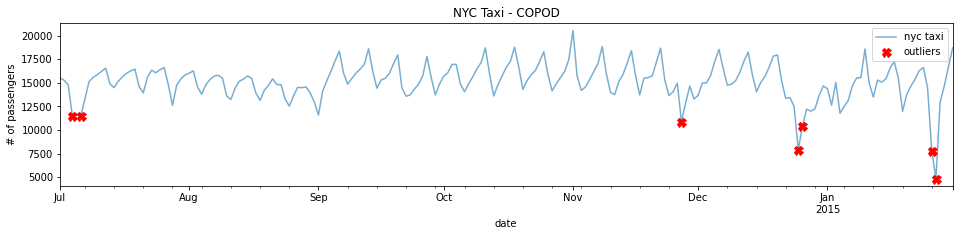

In [46]:
# Use the plot_outliers function

plot_outliers(outliers, tx, 'COPOD')

Another simple and popular probabilistic algo is the Median Absolute Deviation (MAD). 

This implementation provided by PyOD takes one parameter, the threshold. The threshold is based on the standard deviation. 



In [47]:
from pyod.models.mad import MAD 
mad = MAD(threshold=3)
predicted = pd.Series(mad.fit_predict(tx), index=tx.index)

outliers = predicted[predicted==1]
outliers = tx.loc[outliers.index]
outliers 

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667
